In [1]:
''' basic package '''
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
''' tensorflow package '''
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib import rnn
mnist = input_data.read_data_sets("../RNN/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../RNN/tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../RNN/tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../RNN/tmp/data/t10k-images-idx3-ubyte.gz
Extracting ../RNN/tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Label:  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
Data shape:  (784,)


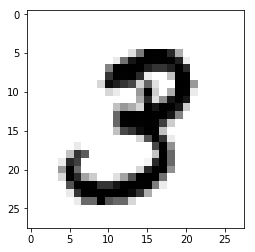

In [2]:
#show training data
print('Label: ', mnist.train.labels[1])
print('Data shape: ', mnist.train.images[1].shape)
plt.figure(figsize=(6, 4))
plt.imshow(mnist.train.images[1].reshape(28, 28), cmap='binary')

# Config

In [3]:
time_step = 28
n_input = 28
hidden_layer_size = 32
number_of_layers = 1
dropout = True
dropout_rate=0.8
learning_rate = 0.001
n_classes = 10
batch_size = 128

# Train

In [4]:
def RNN_cell(hidden_layer_size, X, number_of_layers, dropout=True, dropout_rate=0.8):
    def get_RNN(hidden_layer_size, dropout, dropout_rate):
        layer = tf.contrib.rnn.BasicRNNCell(hidden_layer_size)

        if dropout:
            layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        return layer
        
    cell = tf.contrib.rnn.MultiRNNCell([get_RNN(hidden_layer_size, dropout, dropout_rate) for _ in range(number_of_layers)])
    init_state = cell.zero_state(tf.shape(X)[0], tf.float32)
    
    return cell, init_state

### Tensorflow 靜態圖

In [6]:
import tensorflow as tf

In [42]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    
    with tf.name_scope('inputs'):
        X = tf.placeholder(tf.float32, shape=[None, time_step, n_input], name='X')
        y = tf.placeholder(tf.float32, shape=[None, n_classes], name='y')
        keep_prob = tf.placeholder(tf.float32, shape=[], name='keep_prob')
        
    with tf.variable_scope('RNN_layer'):
        cell, init_state = RNN_cell(hidden_layer_size, X, number_of_layers, dropout, keep_prob)
        outputs, states = tf.nn.dynamic_rnn(cell, X, initial_state=init_state)
        
    with tf.variable_scope('output_layer'):
        RNN_last_outputs = outputs[:, -1, :]
        prediction = tf.layers.dense(inputs=RNN_last_outputs, units=10)
        
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=prediction))
        
    with tf.name_scope('optimizer'):
        opti = tf.train.AdamOptimizer(learning_rate).minimize(loss)
        
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))
        
    init = tf.global_variables_initializer()

### Training Start

In [44]:
sess.run(init)

iter = 1
while iter < 1001:
    batch_X, batch_y = mnist.train.next_batch(batch_size=batch_size)
    
    batch_X = batch_X.reshape((batch_size, time_step, n_input))
    
    sess.run(opti, feed_dict={X: batch_X, y: batch_y, keep_prob: 0.8})
    
    if iter % 200 == 0:
        acc, loss_ = sess.run([accuracy, loss], feed_dict={X: batch_X, y: batch_y, keep_prob: 0.8})
#         acc=sess.run(accuracy,feed_dict={X:batch_X,y:batch_y, keep_prob: 0.8})
        print('Iter: ', iter)
        print('Accuracy: ', acc, ', Loss: ', loss_)
        print('----------------------------------')
    iter += 1

Iter:  200
Accuracy:  0.578125 , Loss:  1.31136
----------------------------------
Iter:  400
Accuracy:  0.632812 , Loss:  1.0185
----------------------------------
Iter:  600
Accuracy:  0.820312 , Loss:  0.623844
----------------------------------
Iter:  800
Accuracy:  0.757812 , Loss:  0.864497
----------------------------------
Iter:  1000
Accuracy:  0.6875 , Loss:  0.886214
----------------------------------


In [45]:
test_X = mnist.test.images[:128].reshape((-1, time_step, n_input))
test_y = mnist.test.labels[:128]
test_acc = sess.run(accuracy, feed_dict={X: test_X, y: test_y, keep_prob: 1.0})
print('Test accuracy: ', test_acc)

sess.close()

Test accuracy:  0.773438


## 練習
1. 把RNN cell換成LSTM觀察Accuracy是否會上升?

In [33]:
def LSTM_cell(hidden_layer_size, X, number_of_layers, dropout=True, dropout_rate=0.8):
    def get_LSTM(hidden_layer_size, dropout, dropout_rate):
#         layer = tf.contrib.rnn.LSTMCell(hidden_layer_size)
        layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)

        if dropout:
            layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        return layer
        
    cell = tf.contrib.rnn.MultiRNNCell([get_LSTM(hidden_layer_size, dropout, dropout_rate) for _ in range(number_of_layers)])
    init_state = cell.zero_state(tf.shape(X)[0], tf.float32)
    
    return cell, init_state

In [37]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    
    with tf.name_scope('inputs'):
        X = tf.placeholder(tf.float32, shape=[None, time_step, n_input], name='X')
        y = tf.placeholder(tf.float32, shape=[None, n_classes], name='y')
        keep_prob = tf.placeholder(tf.float32, shape=[], name='keep_prob')
        
    with tf.variable_scope('LSTM_layer'):
        cell, init_state = LSTM_cell(hidden_layer_size, X, number_of_layers, dropout, keep_prob)
        outputs, states = tf.nn.dynamic_rnn(cell, X, initial_state=init_state)
        
    with tf.variable_scope('output_layer'):
        LSTM_last_outputs = outputs[:, -1, :]
        prediction = tf.layers.dense(inputs=LSTM_last_outputs, units=n_classes)
        
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y))
        
    with tf.name_scope('optimizer'):
        opti = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    init = tf.global_variables_initializer()

### Training Start

In [39]:
sess.run(init)

iter = 1
while iter < 1001:
    
    batch_X, batch_y = mnist.train.next_batch(batch_size)
    batch_X = batch_X.reshape((batch_size, time_step, n_input))
    
    sess.run(opti, feed_dict={X: batch_X, y: batch_y, keep_prob: 0.8})
    
    if iter % 200 == 0:
        loss_, acc = sess.run([loss, accuracy], feed_dict={X: batch_X, y: batch_y, keep_prob: 0.8})
        print('Iter: ', iter)
        print('Accuracy: ', acc, ', Loss: ', loss_)
        print('----------------------------------')
    iter += 1

Iter:  200
Accuracy:  0.703125 , Loss:  0.892288
----------------------------------
Iter:  400
Accuracy:  0.84375 , Loss:  0.556373
----------------------------------
Iter:  600
Accuracy:  0.9375 , Loss:  0.273426
----------------------------------
Iter:  800
Accuracy:  0.929688 , Loss:  0.284311
----------------------------------


In [40]:
test_X = mnist.test.images[:128].reshape((-1, time_step, n_input))
test_y = mnist.test.labels[:128]
test_acc = sess.run(accuracy, feed_dict={X: test_X, y: test_y, keep_prob: 1.0})
print('Test accuracy: ', test_acc)

sess.close()

Test accuracy:  0.921875


## 練習
2. 把RNN cell換成GRU觀察Accuracy是否會上升?

In [53]:
def GRU_cell(hidden_layer_size, X, number_of_layers, dropout=True, dropout_rate=0.8):
    def get_GRU(hidden_layer_size, dropout, dropout_rate):
        layer = tf.contrib.rnn.GRUCell(hidden_layer_size)
        
        if dropout:
            layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        return layer
    cell = tf.contrib.rnn.MultiRNNCell([get_GRU(hidden_layer_size, dropout, dropout_rate) for _ in range(number_of_layers)])
    init_state = cell.zero_state(tf.shape(X)[0], tf.float32)
    
    return cell, init_state

In [56]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    with tf.name_scope('inputs'):
        X = tf.placeholder(tf.float32, shape=[None, time_step, n_input], name='X')
        y = tf.placeholder(tf.float32, shape=[None, n_classes], name='y')
        keep_prob = tf.placeholder(tf.float32, shape=[], name='keep_prob')
        
    with tf.variable_scope('GRU_layer'):
        cell, init_state = GRU_cell(hidden_layer_size, X, number_of_layers, dropout, keep_prob)
        outputs, states = tf.nn.dynamic_rnn(cell, X, initial_state=init_state)
        
    with tf.variable_scope('output_layer'):
        GRU_last_layer = outputs[:, -1, :]
        prediction = tf.layers.dense(inputs=GRU_last_layer, units=n_classes)
        
    with tf.variable_scope('loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y))
        
    with tf.name_scope('optimizer'):
        opti = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    init = tf.global_variables_initializer()

In [58]:
sess.run(init)

iter = 1
while iter < 1001:
    
    batch_X, batch_y = mnist.train.next_batch(batch_size)
    batch_X = batch_X.reshape((batch_size, time_step, n_input))
    
    sess.run(opti, feed_dict={X: batch_X, y: batch_y, keep_prob: 0.8})
    
    if iter % 200 == 0:
        loss_, acc = sess.run([loss, accuracy], feed_dict={X: batch_X, y: batch_y, keep_prob: 0.8})
        print('Iter: ', iter)
        print('Accuracy: ', acc, ', Loss: ', loss_)
        print('----------------------------------')
    iter += 1

Iter:  200
Accuracy:  0.65625 , Loss:  0.979548
----------------------------------
Iter:  400
Accuracy:  0.773438 , Loss:  0.694255
----------------------------------
Iter:  600
Accuracy:  0.929688 , Loss:  0.380879
----------------------------------
Iter:  800
Accuracy:  0.953125 , Loss:  0.206276
----------------------------------
Iter:  1000
Accuracy:  0.9375 , Loss:  0.2627
----------------------------------


In [59]:
test_X = mnist.test.images[:128].reshape((-1, time_step, n_input))
test_y = mnist.test.labels[:128]
test_acc = sess.run(accuracy, feed_dict={X: test_X, y: test_y, keep_prob: 1.0})
print('Test accuracy: ', test_acc)

sess.close()

Test accuracy:  0.96875


-----------------------------------------

把手寫數字兩張平行輸入到model預測，輸入資料變成time_step = 28, input_data_dimension = 56

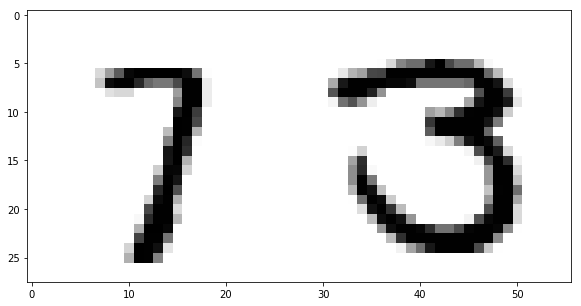

In [63]:
plt.figure(figsize=(10, 5))
img1 = mnist.train.images[2].reshape(28, 28)
img2 = mnist.train.images[3].reshape(28, 28)
img = np.concatenate((img1, img2), axis=1)
plt.imshow(img, cmap='binary')

In [64]:
time_step = 28
n_input = 56
hidden_layer_size = 32
number_of_layers = 1
dropout = True
dropout_rate=0.8
learning_rate = 0.001
n_classes = 10
batch_size = 128

In [68]:
def GRU_cell(hidden_layer_size, X, number_of_layers, dropout=True, dropout_rate=0.8):
    def get_GRU(hidden_layer_size, dropout, dropout_rate):
        layer = tf.contrib.rnn.GRUCell(hidden_layer_size)
        
        if dropout:
            layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        return layer
    cell = tf.contrib.rnn.MultiRNNCell([get_GRU(hidden_layer_size, dropout, dropout_rate) for _ in range(number_of_layers)])
    init_state = cell.zero_state(tf.shape(X)[0], tf.float32)
    
    return cell, init_state

def output_layer(outputs, n_classes):
    last_layer = outputs[:, -1, :]
    prediction = tf.layers.dense(inputs=last_layer, units=n_classes)
    
    return prediction

In [70]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    with tf.name_scope('inputs'):
        X = tf.placeholder(tf.float32, shape=[None, time_step, n_input], name='X')
        y1 = tf.placeholder(tf.float32, shape=[None, n_classes], name='y1')
        y2 = tf.placeholder(tf.float32, shape=[None, n_classes], name='y2')
        keep_prob = tf.placeholder(tf.float32, shape=[], name='keep_prob')
        
    with tf.variable_scope('GRU_layer'):
        cell, init_state = GRU_cell(hidden_layer_size, X, number_of_layers, dropout, keep_prob)
        outputs, states = tf.nn.dynamic_rnn(cell, X, initial_state=init_state)
        
    with tf.variable_scope('output1_layer'):
        prediction1 = output_layer(outputs, n_classes)    
    with tf.variable_scope('output2_layer'):
        prediction2 = output_layer(outputs, n_classes)
        
    with tf.variable_scope('loss'):
        loss1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction1, labels=y1))
        loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction2, labels=y2))
        loss = loss1 + loss2
        
    with tf.name_scope('optimizer'):
        opti = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        
    with tf.name_scope('accuracy'):
        correct_prediction = tf.logical_and(tf.equal(tf.argmax(prediction1, 1), tf.argmax(y1, 1)), tf.equal(tf.argmax(prediction2, 1), tf.argmax(y2, 1)))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    init = tf.global_variables_initializer()

In [77]:
sess.run(init)

iter = 1
while iter < 10001:
    
    batch_X1, batch_y1 = mnist.train.next_batch(batch_size)
    batch_X2, batch_y2 = mnist.train.next_batch(batch_size)
    batch_X1 = batch_X1.reshape(128, 28, 28)
    batch_X2 = batch_X2.reshape(128, 28, 28)
    batch_X = np.concatenate((batch_X1, batch_X2), axis=2)
    
    sess.run(opti, feed_dict={X: batch_X, y1: batch_y1, y2: batch_y2, keep_prob: 0.8})
    
    if iter % 2000 == 0:
        loss_, acc = sess.run([loss, accuracy], feed_dict={X: batch_X, y1: batch_y1, y2: batch_y2, keep_prob: 0.8})
        print('Iter: ', iter)
        print('Accuracy: ', acc, ', Loss: ', loss_)
        print('----------------------------------')
    iter += 1

Iter:  2000
Accuracy:  0.710938 , Loss:  0.914318
----------------------------------
Iter:  4000
Accuracy:  0.882812 , Loss:  0.576342
----------------------------------
Iter:  6000
Accuracy:  0.859375 , Loss:  0.566588
----------------------------------
Iter:  8000
Accuracy:  0.882812 , Loss:  0.444667
----------------------------------
Iter:  10000
Accuracy:  0.921875 , Loss:  0.258174
----------------------------------
